## DICOM FILE HANDLING

## Imports

In [1]:
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt
import numpy as np

At first we try to read a single dcm file <br />
To this end we use the **read_file(path)** function provided by pydicom

In [2]:
dcm_file = pydicom.read_file("ID_0000_AGE_0060_CONTRAST_1_CT.dcm")

You can *print* the dicom file to get a bulk of information, containing e.g the company which built the scanner (SIEMENS in this case), the shape of the image (*Rows, Columns*, 512x512 in this case), table height all information about the patient (of course the personal information is anonymized here), and of large importance, the **image orientation**


In [22]:
print(dcm_file)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.108821836759549281694712274169
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 430
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.1088

Accessing DICOM **header** information:
You can access the dicom tags by using the hexadecimal encoded identifiers at the start of each line.
As an example, if you want to get the shape of the image you can use those two identifiers

* (0028, 0010) Rows
* (0028, 0011) Columns
* (0018, 0015) Body Part Examined

The 0x in front of the identifier tells the python interpreter that it should interpret this value as hexadecimal

In [4]:
dcm_file[0x0010, 0x0010]

(0010, 0010) Patient's Name                      PN: 'TCGA-17-Z034'

Accessing DICOM **body** information (the actual image):

The **pixel_array** contains the actual image data:

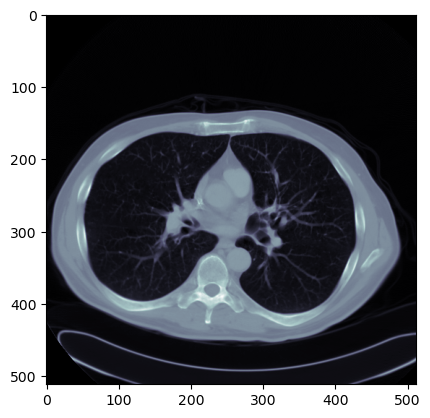

In [5]:
ct = dcm_file.pixel_array
plt.figure()
plt.imshow(ct, cmap="bone")

In [6]:
print(ct.shape)

(512, 512)


## 3D Data
 

In [7]:
path_to_head_mri = Path("SE000001/")

We can use the glob function to return all items in a directory which correspond to the provided pattern. <br />
As in this case, the directory only contains the DICOM files, we can return all files in it ("*")

In [8]:
all_files = list(path_to_head_mri.glob("*")) # wildcard

It crucial to order them, as otherwise your complete scan would be shuffeled and useless

In [9]:
all_files.sort() # dicom file slices should be ordered !!! thats crucial
all_files

[WindowsPath('SE000001/MR000000'),
 WindowsPath('SE000001/MR000001'),
 WindowsPath('SE000001/MR000002'),
 WindowsPath('SE000001/MR000003'),
 WindowsPath('SE000001/MR000004'),
 WindowsPath('SE000001/MR000005'),
 WindowsPath('SE000001/MR000006'),
 WindowsPath('SE000001/MR000007'),
 WindowsPath('SE000001/MR000008'),
 WindowsPath('SE000001/MR000009'),
 WindowsPath('SE000001/MR000010'),
 WindowsPath('SE000001/MR000011'),
 WindowsPath('SE000001/MR000012'),
 WindowsPath('SE000001/MR000013'),
 WindowsPath('SE000001/MR000014'),
 WindowsPath('SE000001/MR000015'),
 WindowsPath('SE000001/MR000016'),
 WindowsPath('SE000001/MR000017'),
 WindowsPath('SE000001/MR000018'),
 WindowsPath('SE000001/MR000019'),
 WindowsPath('SE000001/MR000020'),
 WindowsPath('SE000001/MR000021'),
 WindowsPath('SE000001/MR000022'),
 WindowsPath('SE000001/MR000023'),
 WindowsPath('SE000001/MR000024'),
 WindowsPath('SE000001/MR000025'),
 WindowsPath('SE000001/MR000026')]

Now we will read these files by using the read_file method and append them to a list

In [10]:
mri_datas = []

for path in all_files:
    mri_datas.append(pydicom.read_file(path))

To see if dicom data is in right order we can use "SliceLocation" attribute.

In [11]:
for slice in mri_datas[:5]:
    print(slice.SliceLocation) # slice location is telling us the relative location of the slices recording to coordinate system.
    # it can be obtain from dicom files. You can find it at (0020, 1041) at every dicom files. To be sorted this slice locations should be
    # in ascending order. First slice should have slice location of 0, second should be more than 0 and so on.
    
# They are in right order because we ordered the files before fetching the file contents in all_files array.

0.0
5.99999663091323
11.9999973042441
17.9999979772582
23.9999946081714


Now we extract the actual data (pixel_arrays) from the Dicom files and store them in a list

In [12]:
full_volume = []

for slices in mri_datas:
    full_volume.append(slices.pixel_array)

And now we can take a look at some slices of the ordered 3D volume:

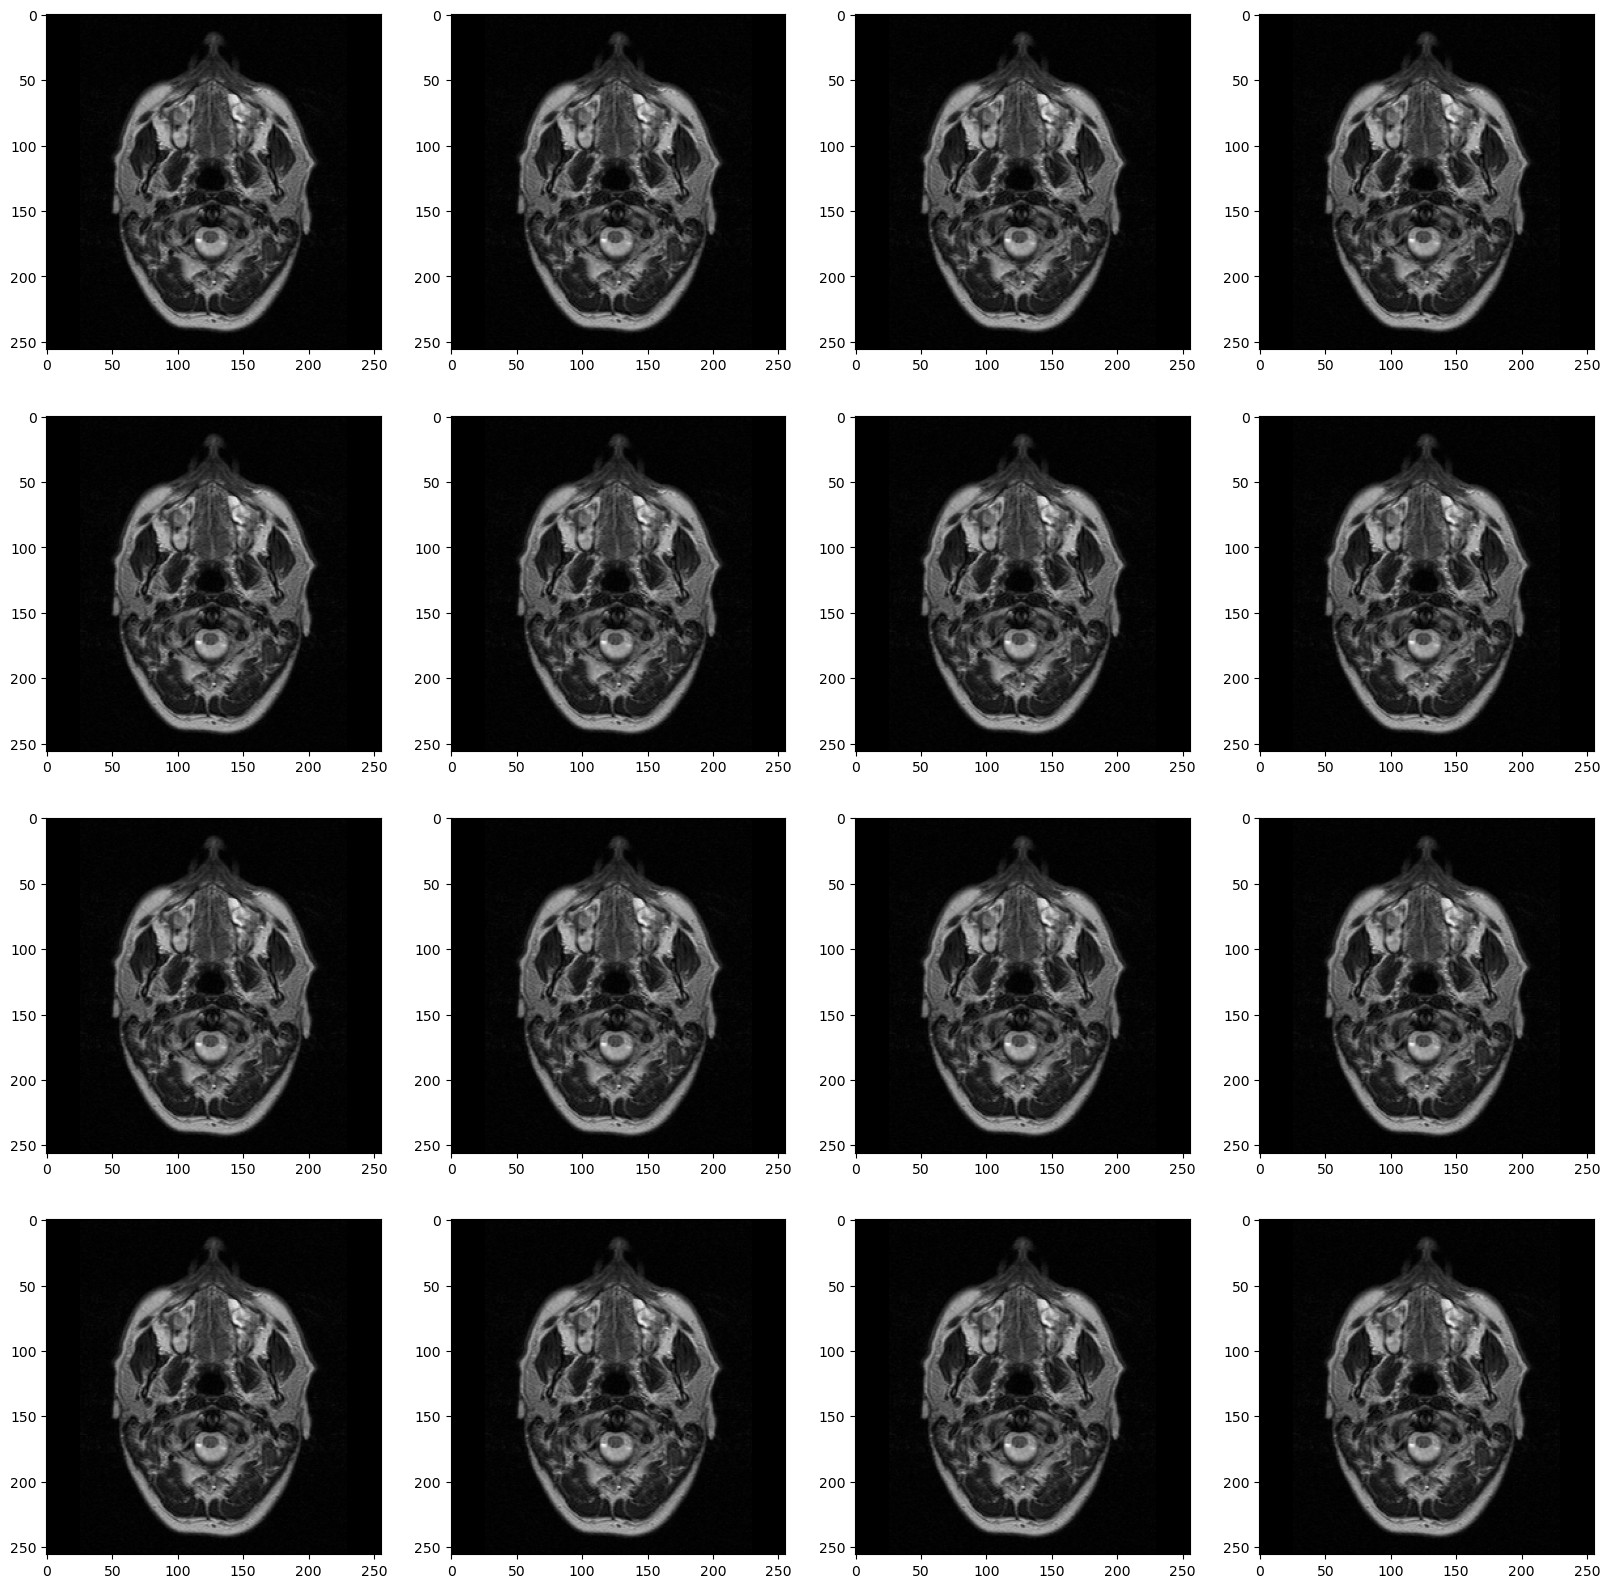

In [13]:
fig, axis = plt.subplots(4, 4, figsize = (20, 20))

slice_counter = 0
for i in range(0,4):
    for j in range(0,4):
        axis[i][j].imshow(full_volume[ slice_counter], cmap = "gray")

In [14]:
import SimpleITK as sitk

In [15]:
series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(path_to_head_mri))
series_ids

('1.3.46.670589.11.0.0.11.4.2.0.12098.5.4500.2015011413262801702',)

In [16]:
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(path_to_head_mri), *series_ids)
series_file_names

('SE000001\\MR000000',
 'SE000001\\MR000001',
 'SE000001\\MR000002',
 'SE000001\\MR000003',
 'SE000001\\MR000004',
 'SE000001\\MR000005',
 'SE000001\\MR000006',
 'SE000001\\MR000007',
 'SE000001\\MR000008',
 'SE000001\\MR000009',
 'SE000001\\MR000010',
 'SE000001\\MR000011',
 'SE000001\\MR000012',
 'SE000001\\MR000013',
 'SE000001\\MR000014',
 'SE000001\\MR000015',
 'SE000001\\MR000016',
 'SE000001\\MR000017',
 'SE000001\\MR000018',
 'SE000001\\MR000019',
 'SE000001\\MR000020',
 'SE000001\\MR000021',
 'SE000001\\MR000022',
 'SE000001\\MR000023',
 'SE000001\\MR000024',
 'SE000001\\MR000025',
 'SE000001\\MR000026')

In [17]:
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)

In [18]:
image_data = series_reader.Execute()

In [19]:
head_mri = sitk.GetArrayFromImage(image_data)

In [20]:
head_mri.shape

(27, 256, 256)

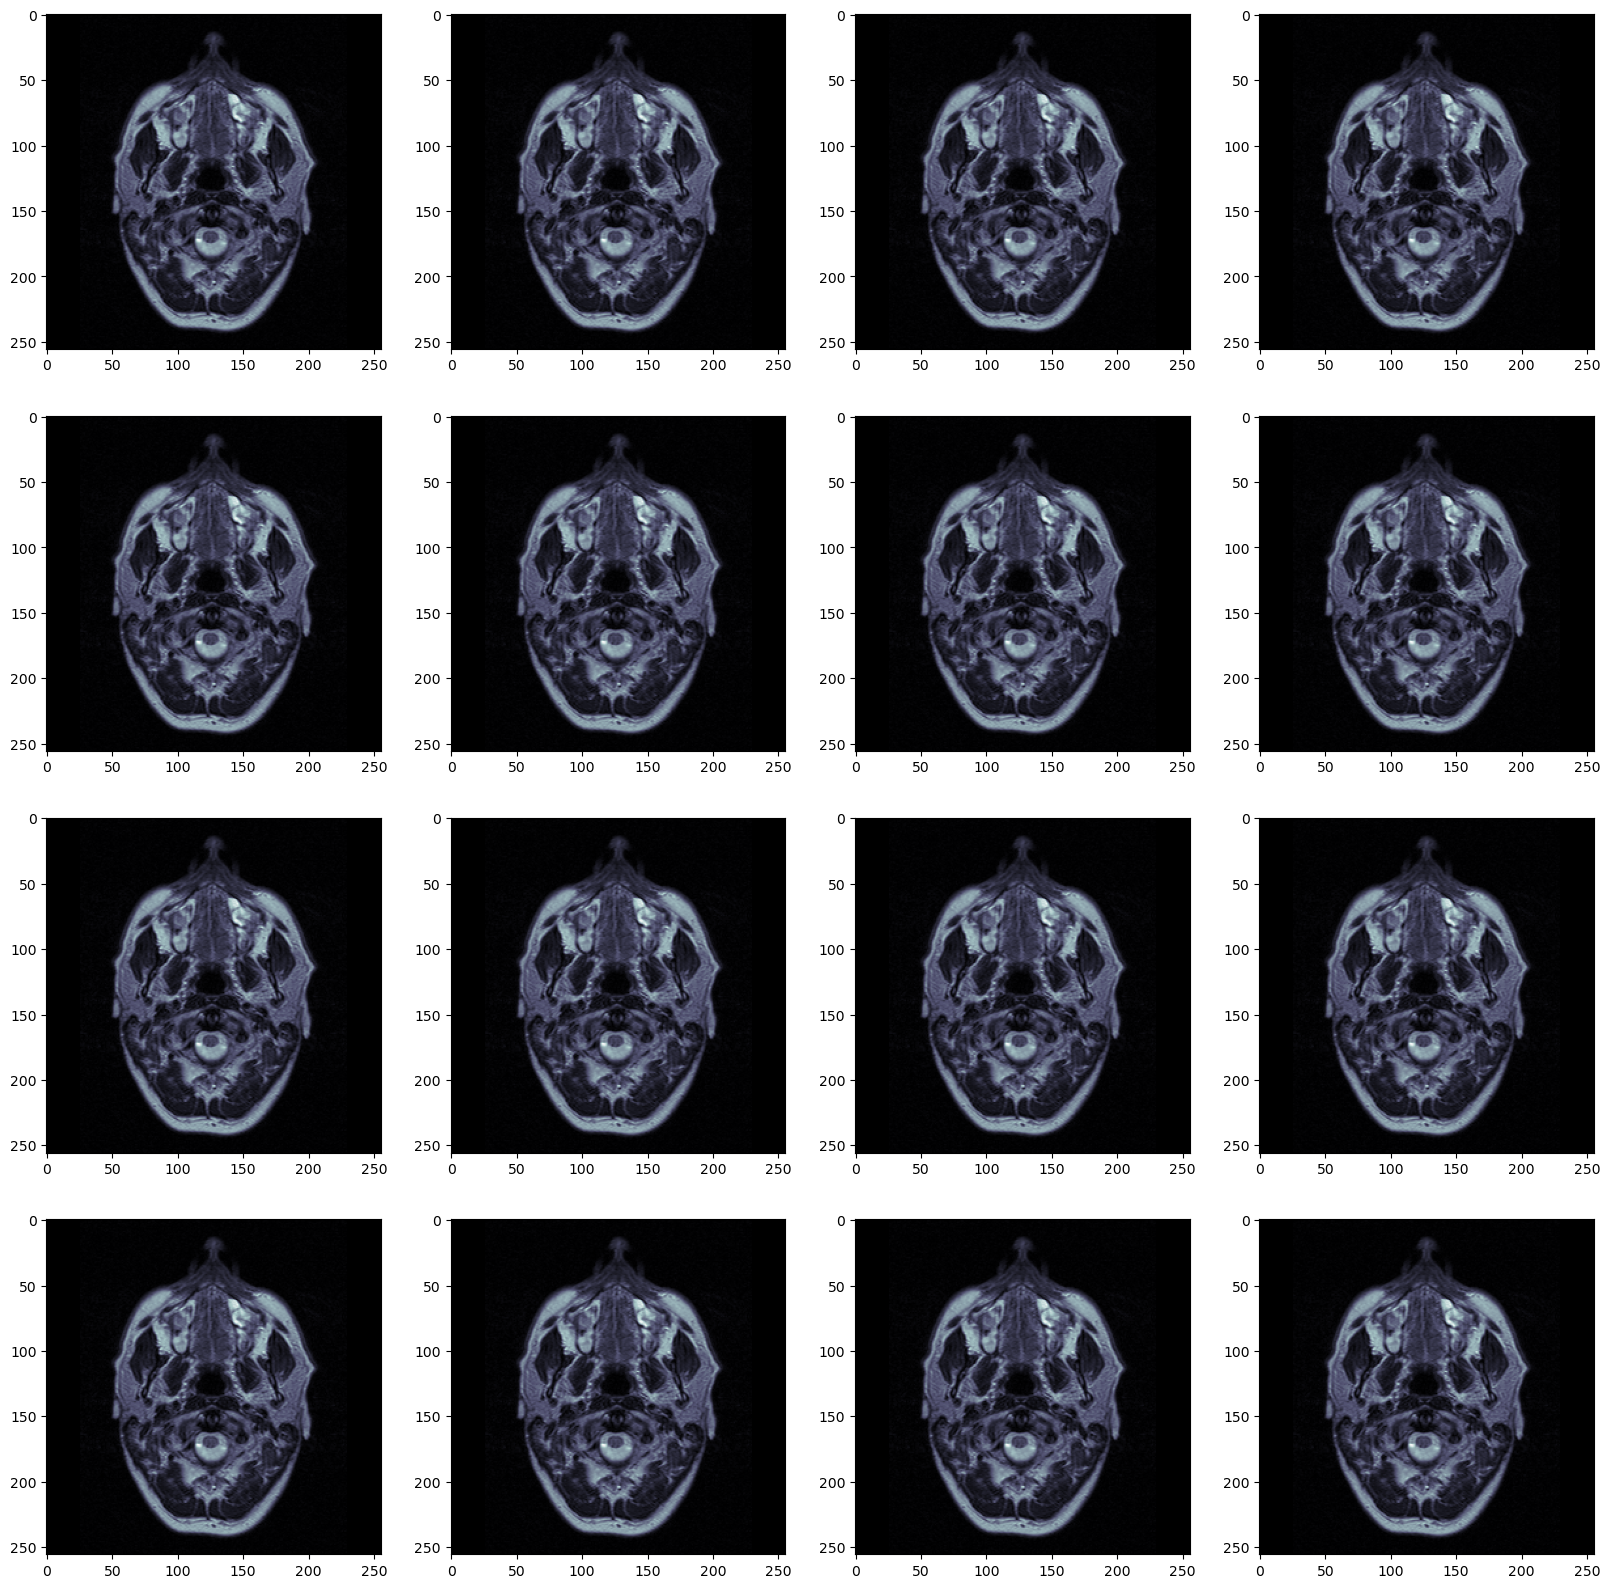

In [21]:
fig, axis = plt.subplots(4, 4, figsize = (20, 20))

slice_counter = 0
for i in range(0,4):
    for j in range(0,4):
        axis[i][j].imshow(head_mri[ slice_counter], cmap = "bone")
